In [1]:
import numpy as np
import pandas as pd

#ploting
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
#models
from sklearn. neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

#for CV
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV #CV?

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

#Asociation rules
from mlxtend.frequent_patterns import apriori, association_rules

## Loading the data

In [2]:
df = pd.read_csv('./data/sleepdata.csv',delimiter=";")
df

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,8:32,:),NaN,59.0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,0:16,:|,Stressful day,72.0,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,8:30,:|,NaN,57.0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,7:32,NaN,NaN,NaN,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,6:44,:),Drank coffee:Drank tea,68.0,0
...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91%,9:08,NaN,NaN,NaN,56
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81%,7:11,NaN,NaN,NaN,64
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71%,8:56,NaN,NaN,NaN,3316
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80%,9:13,NaN,NaN,NaN,6555


Displaying the info of the dataset

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Start             887 non-null    object 
 1   End               887 non-null    object 
 2   Sleep quality     887 non-null    object 
 3   Time in bed       887 non-null    object 
 4   Wake up           246 non-null    object 
 5   Sleep Notes       652 non-null    object 
 6   Heart rate        162 non-null    float64
 7   Activity (steps)  887 non-null    int64  
dtypes: float64(1), int64(1), object(6)
memory usage: 55.6+ KB


In [4]:
df.head()

,Start,End,Sleep quality,Time in bed,Wake up,Sleep Notes,Heart rate,Activity (steps)
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100%,8:32,:),NaN,59.0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3%,0:16,:|,Stressful day,72.0,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98%,8:30,:|,NaN,57.0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65%,7:32,NaN,NaN,NaN,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72%,6:44,:),Drank coffee:Drank tea,68.0,0


## Cleaning the data

[Text(0.5, 1.0, 'Values of the dataset that are null')]

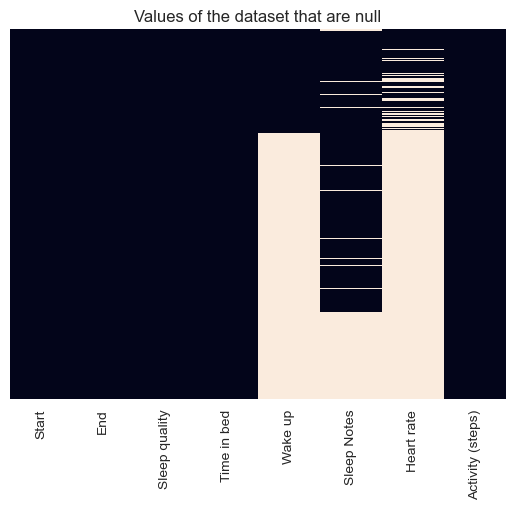

In [5]:
sns.heatmap(df.isnull(),yticklabels=False,cbar=False).set(title='Values of the dataset that are null')

As we can see in the graph the columns "heart rate" and "Wake up" are mostly null. However, the wake up column is not important for predicting the result of sleep quality. Because the mood when you wake up is a consequence of the sleep quality and not the opposite and the heart rate is 86% null values so it is not possible to extract information from that column.

In [6]:
#Drop the columns 'Wake up' and 'Heart rate'
df_cleaned=df.drop(columns=['Wake up','Heart rate'])

Another colum with lots of nulls is the column sleep notes but in this case null means that there are no extra notes for that nigth.

In [7]:
df_cleaned['Sleep Notes'].fillna(value = '', inplace = True)

[Text(0.5, 1.0, 'Values of the dataset that are null')]

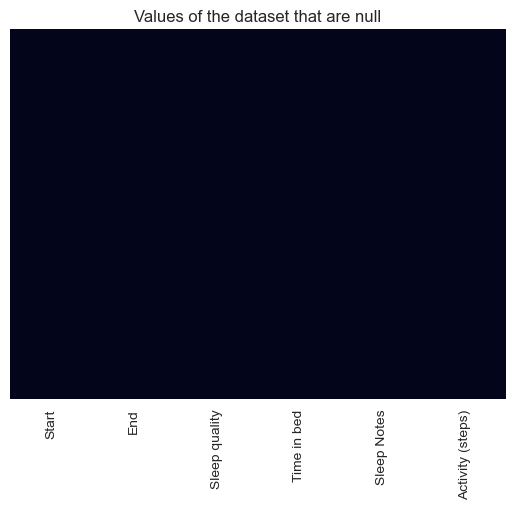

In [8]:
sns.heatmap(df_cleaned.isnull(),yticklabels=False,cbar=False).set(title='Values of the dataset that are null')

Transforming the 'Start' and 'End' columns to datetime type and the 'Time in bed' to seconds.

In [9]:
df_cleaned['Start'] = pd.to_datetime(df_cleaned['Start'])
df_cleaned['End'] = pd.to_datetime(df_cleaned['End'])
df_cleaned['Time in bed'] = (df_cleaned['End'] - df_cleaned['Start']).astype('timedelta64[s]')
df_cleaned['Sleep quality'] = df_cleaned['Sleep quality'].apply(lambda x: np.nan if x in ['-'] else x[:-1]).astype(int)
df_cleaned['Start time'] = pd.Series([val.time() for val in df_cleaned['Start']])
df_cleaned['End time'] = pd.Series([val.time() for val in df_cleaned['End']])
df_cleaned['Start time in second'] = df_cleaned['Start'].apply(lambda x: (x.hour*60+x.minute)*60 + x.second)
df_cleaned['End time in second'] = df_cleaned['End'].apply(lambda x: (x.hour*60+x.minute)*60 + x.second)

In [10]:
df_cleaned

,Start,End,Sleep quality,Time in bed,Sleep Notes,Activity (steps),Start time,End time,Start time in second,End time in second
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100,30744.0,,0,22:57:49,07:30:13,82669,27013
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3,964.0,Stressful day,0,21:17:50,21:33:54,76670,77634
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98,30642.0,,0,22:42:49,07:13:31,81769,26011
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65,27120.0,,0,22:31:01,06:03:01,81061,21781
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72,24265.0,Drank coffee:Drank tea,0,22:12:10,04:56:35,79930,17795
...,...,...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91,32881.0,,56,21:54:14,07:02:15,78854,25335
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81,25894.0,,64,23:49:19,07:00:53,85759,25253
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71,32207.0,,3316,21:24:05,06:20:52,77045,22852
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80,33239.0,,6555,21:36:32,06:50:31,77792,24631


In [11]:
sleep_notes_values=np.unique(df_cleaned['Sleep Notes'].apply(lambda x: x.split(':')).sum())
sleep_notes_values=sleep_notes_values[1:]
print("All the different values for the Sleep notes: "+str(sleep_notes_values))

All the different values for the Sleep notes: ['Ate late' 'Drank coffee' 'Drank tea' 'Stressful day' 'Worked out']


Transform the categorical of 'Sleep notes' into dummy/indicator variables.

In [12]:
for v in sleep_notes_values:
    df_cleaned[v] = df_cleaned['Sleep Notes'].apply(lambda x: v in x).astype(int)

In [13]:
df_cleaned

,Start,End,Sleep quality,Time in bed,Sleep Notes,Activity (steps),Start time,End time,Start time in second,End time in second,Ate late,Drank coffee,Drank tea,Stressful day,Worked out
0,2014-12-29 22:57:49,2014-12-30 07:30:13,100,30744.0,,0,22:57:49,07:30:13,82669,27013,0,0,0,0,0
1,2014-12-30 21:17:50,2014-12-30 21:33:54,3,964.0,Stressful day,0,21:17:50,21:33:54,76670,77634,0,0,0,1,0
2,2014-12-30 22:42:49,2014-12-31 07:13:31,98,30642.0,,0,22:42:49,07:13:31,81769,26011,0,0,0,0,0
3,2014-12-31 22:31:01,2015-01-01 06:03:01,65,27120.0,,0,22:31:01,06:03:01,81061,21781,0,0,0,0,0
4,2015-01-01 22:12:10,2015-01-02 04:56:35,72,24265.0,Drank coffee:Drank tea,0,22:12:10,04:56:35,79930,17795,0,1,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
882,2018-02-12 21:54:14,2018-02-13 07:02:15,91,32881.0,,56,21:54:14,07:02:15,78854,25335,0,0,0,0,0
883,2018-02-13 23:49:19,2018-02-14 07:00:53,81,25894.0,,64,23:49:19,07:00:53,85759,25253,0,0,0,0,0
884,2018-02-14 21:24:05,2018-02-15 06:20:52,71,32207.0,,3316,21:24:05,06:20:52,77045,22852,0,0,0,0,0
885,2018-02-15 21:36:32,2018-02-16 06:50:31,80,33239.0,,6555,21:36:32,06:50:31,77792,24631,0,0,0,0,0


In [14]:
grouped_df = df_cleaned[['Sleep quality', 'Drank tea', 'Drank coffee', 'Worked out', 'Ate late', 'Stressful day']].groupby(['Drank tea', 'Drank coffee', 'Worked out', 'Ate late', 'Stressful day']).mean()
grouped_df

Sleep quality
Drank tea Drank coffee Worked out Ate late Stressful day               
0         0            0          0        0                  70.812766
                                           1                   3.000000
                       1          0        0                  71.000000
          1            0          0        0                  73.306667
                                           1                  86.375000
                                  1        0                  83.500000
                       1          0        0                  73.989011
                                           1                  79.466667
                                  1        0                  80.000000
1         0            0          0        0                  78.827586
                                           1                  93.000000
                       1          0        0                  75.645161
                                           1                  78.800000
          1            0          0        0                  78.837398
                                           1                  79.000000
                                  1        0                  73.000000
                                           1                  72.000000
                       1          0        0                  76.006098
                                           1                  74.307692
                                  1        0                  77.600000

Data grouped by the different sleeping

In [15]:
df_cleaned['Day of week'] = [x.weekday() for x in df_cleaned['Start']]
df_cleaned_days_week=df_cleaned.copy()
df_cleaned_days_week['Day of week'] = df_cleaned['Day of week'].replace({0:'Monday', 1:'Tuesday', 2:'Wednesday', 3:'Thursday', 4:'Friday', 5:'Saturday', 6:'Sunday'})

C:\Users\Aarongp\anaconda3\envs\DataMiningAssignments\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Aarongp\anaconda3\envs\DataMiningAssignments\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


[Text(0.5, 1.0, 'Working out in the week')]

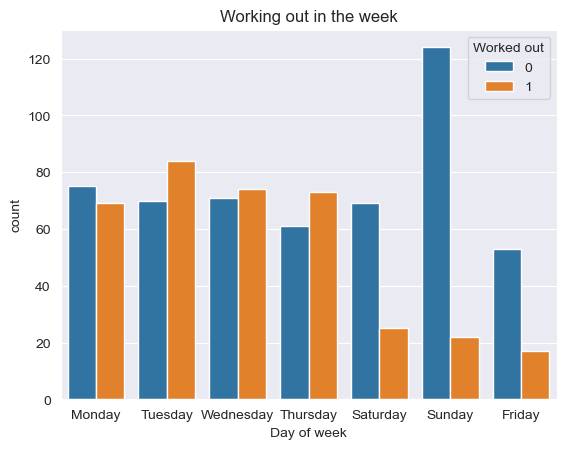

In [16]:
sns.countplot(x = 'Day of week', hue = 'Worked out', data = df_cleaned_days_week).set(title='Working out in the week')

C:\Users\Aarongp\anaconda3\envs\DataMiningAssignments\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Aarongp\anaconda3\envs\DataMiningAssignments\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


[Text(0.5, 1.0, 'Working out in the week')]

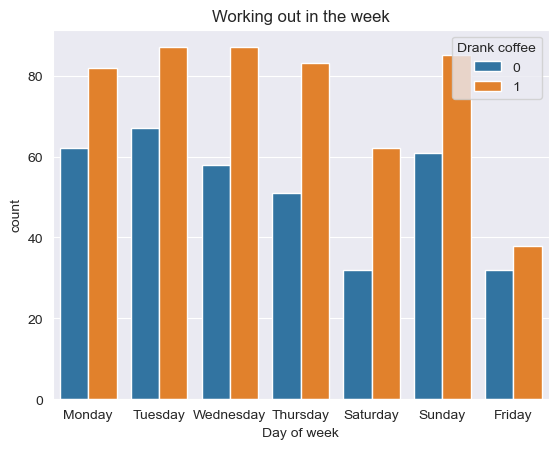

In [17]:
sns.countplot(x = 'Day of week', hue = 'Drank coffee', data = df_cleaned_days_week).set(title='Working out in the week')

C:\Users\Aarongp\anaconda3\envs\DataMiningAssignments\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Aarongp\anaconda3\envs\DataMiningAssignments\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


[Text(0.5, 1.0, 'Drinking tea out in the week')]

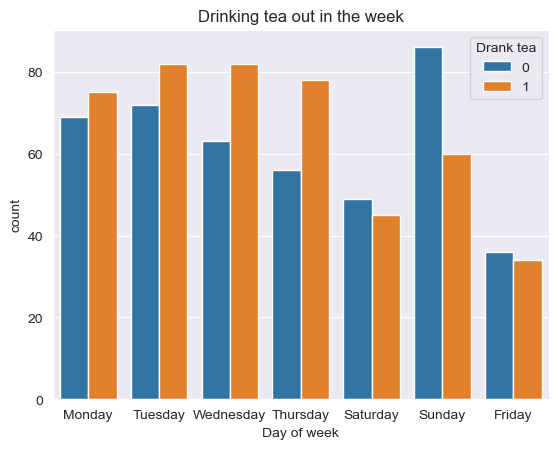

In [18]:
sns.countplot(x = 'Day of week', hue = 'Drank tea', data = df_cleaned_days_week).set(title='Drinking tea out in the week')

C:\Users\Aarongp\anaconda3\envs\DataMiningAssignments\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Aarongp\anaconda3\envs\DataMiningAssignments\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


[Text(0.5, 1.0, 'Eating late in the week')]

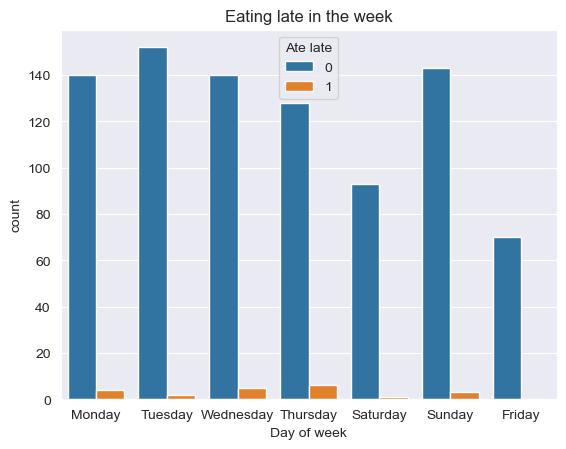

In [19]:
sns.countplot(x = 'Day of week', hue = 'Ate late', data = df_cleaned_days_week).set(title='Eating late in the week')

C:\Users\Aarongp\anaconda3\envs\DataMiningAssignments\lib\site-packages\seaborn\categorical.py:381: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < "3.0":
C:\Users\Aarongp\anaconda3\envs\DataMiningAssignments\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


[Text(0.5, 1.0, 'Stressful day in the week')]

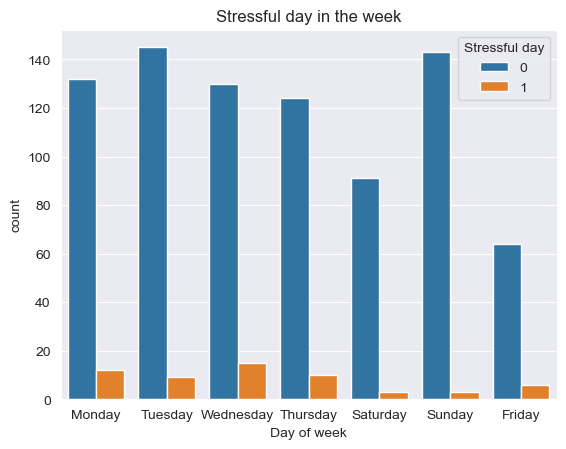

In [20]:
sns.countplot(x = 'Day of week', hue = 'Stressful day', data = df_cleaned_days_week).set(title='Stressful day in the week')

In [21]:
final_dataset=df_cleaned[['Start time in second','End time in second','Time in bed','Activity (steps)','Ate late','Worked out','Drank coffee','Drank tea','Stressful day','Day of week']]
final_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887 entries, 0 to 886
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Start time in second  887 non-null    int64  
 1   End time in second    887 non-null    int64  
 2   Time in bed           887 non-null    float64
 3   Activity (steps)      887 non-null    int64  
 4   Ate late              887 non-null    int32  
 5   Worked out            887 non-null    int32  
 6   Drank coffee          887 non-null    int32  
 7   Drank tea             887 non-null    int32  
 8   Stressful day         887 non-null    int32  
 9   Day of week           887 non-null    int64  
dtypes: float64(1), int32(5), int64(4)
memory usage: 52.1 KB


In [22]:
y=df_cleaned['Sleep quality']
X=final_dataset.values
labels=['Start time in second','End time in second','Time in bed','Activity (steps)','Ate late','Worked out','Drank coffee','Drank tea','Stressful day','Day of week']

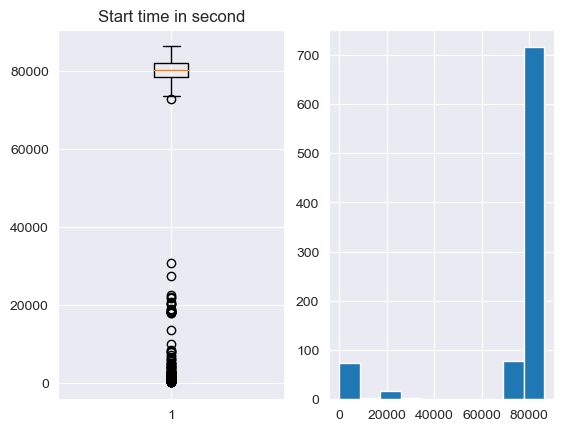

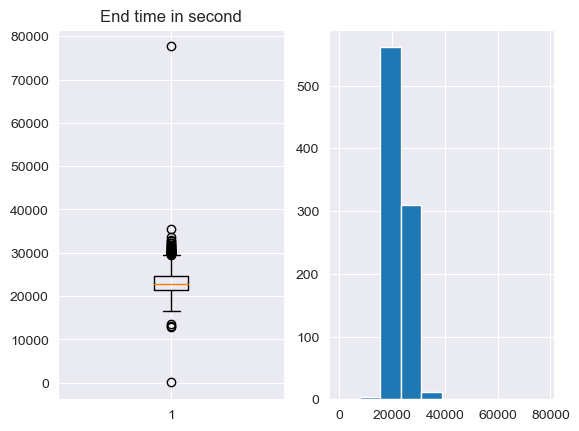

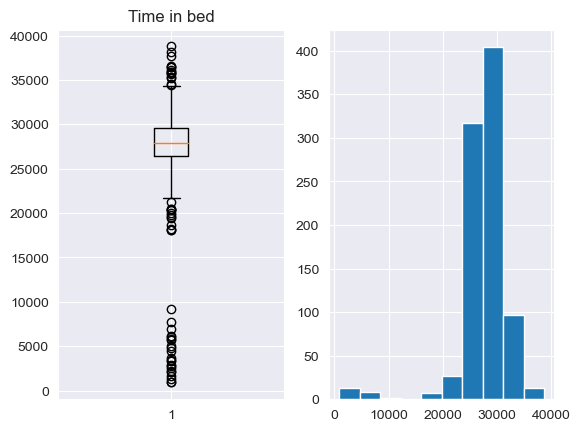

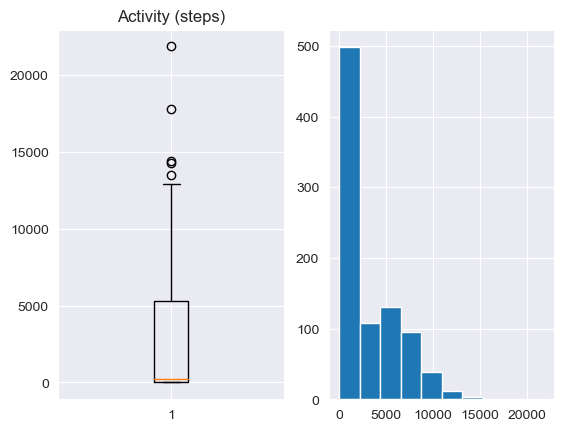

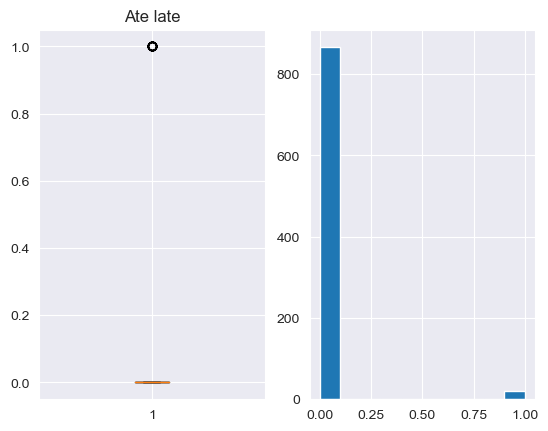

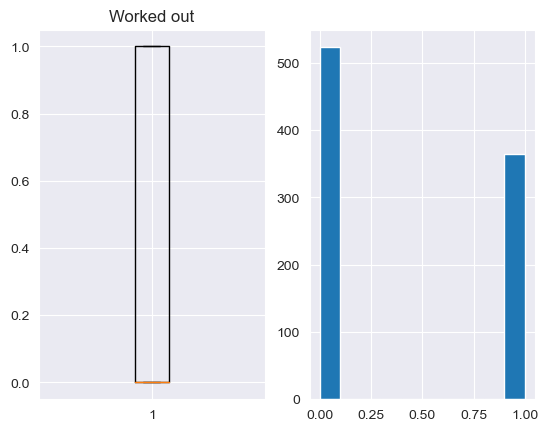

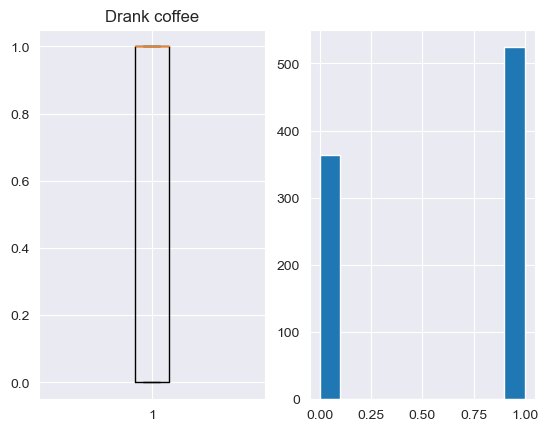

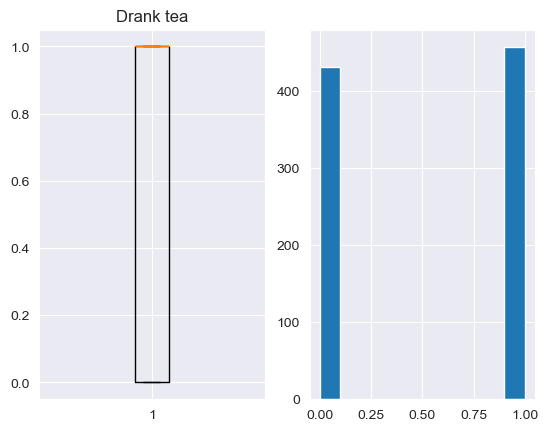

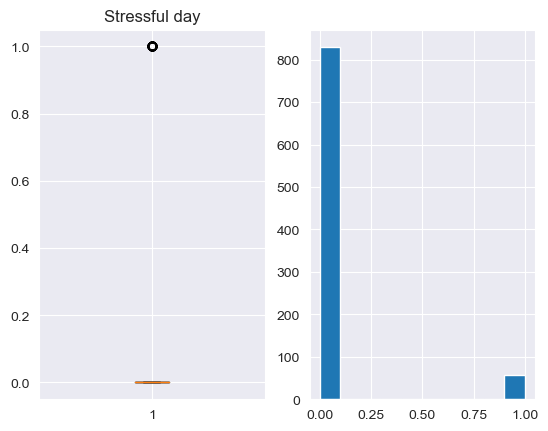

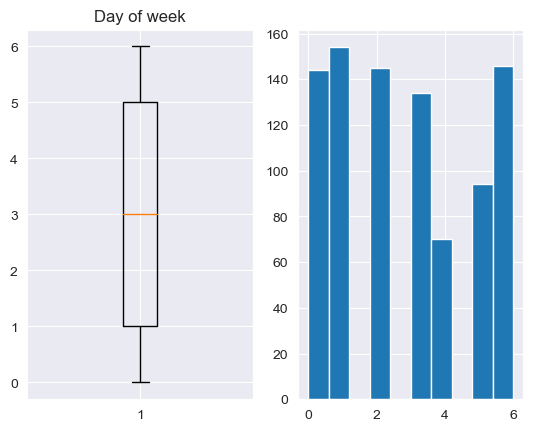

In [23]:
for i in range(len(labels)):
    feat=labels[i]
    fig, ax = plt.subplots(1,2)
    ax[0].boxplot(X[:,i])
    ax[1].hist(X[:,i])
    ax[0].set_title(feat)
    plt.show()

[Text(0.5, 1.0, 'Correlation matrix of the final data')]

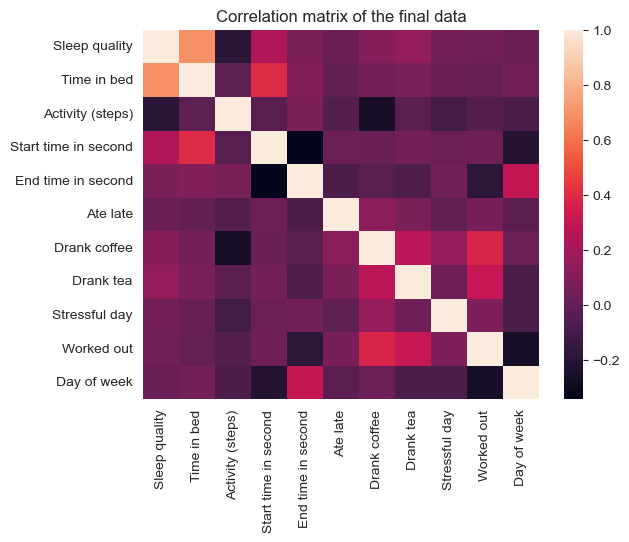

In [24]:
sns.heatmap(df_cleaned.corr()).set(title='Correlation matrix of the final data')

In [25]:
scaler = StandardScaler()

standardized_X = scaler.fit_transform(X)

print(X)
print("####")
print(standardized_X.mean(axis=1), standardized_X.std(axis=1))

[[8.2669e+04 2.7013e+04 3.0744e+04 ... 0.0000e+00 0.0000e+00 0.0000e+00]
 [7.6670e+04 7.7634e+04 9.6400e+02 ... 0.0000e+00 1.0000e+00 1.0000e+00]
 [8.1769e+04 2.6011e+04 3.0642e+04 ... 0.0000e+00 0.0000e+00 1.0000e+00]
 ...
 [7.7045e+04 2.2852e+04 3.2207e+04 ... 0.0000e+00 0.0000e+00 2.0000e+00]
 [7.7792e+04 2.4631e+04 3.3239e+04 ... 0.0000e+00 0.0000e+00 3.0000e+00]
 [8.2349e+04 2.8084e+04 3.2135e+04 ... 0.0000e+00 0.0000e+00 4.0000e+00]]
####
[-3.51049112e-01  7.97490289e-01 -3.35613072e-01 -4.79845729e-01
 -2.01512167e-01 -1.26754460e-01 -2.99159491e-01  4.31473314e-01
 -9.24313039e-02 -2.39658357e-01  4.69687891e-01 -2.14047947e-02
  2.73585349e-01  3.11211619e-01 -1.56116272e-02 -5.09887811e-02
 -5.67980255e-02 -6.15769197e-03 -3.68954225e-01 -5.48944285e-03
  2.84823852e-01 -2.12805651e-01 -1.30599090e+00  2.66620357e-02
  7.71894207e-02  1.64922854e-01  5.14030270e-02  2.51261585e-01
  2.54510445e-01  8.46362584e-02  3.87189691e-01 -3.01503545e-03
 -3.25479046e-01 -9.15686842e-0

## PCA

In [26]:
y_bins=pd.cut(df_cleaned['Sleep quality'], bins=4, labels=False)

n_components=2
pca = PCA(n_components=n_components)

pca_features = pca.fit_transform(standardized_X)

print('Shape before PCA: ', standardized_X.shape)
print('Shape after PCA: ', pca_features.shape)

pca_df = pd.DataFrame(
    data=pca_features,
    columns=['PC1', 'PC2'])

target_names = {
    0:"Between 0 and 25",
    1:"Between 26 and 50",
    2:"Between 51 and 75",
    3:"Between 76 and 100"
}

pca_df['target'] = y_bins
pca_df['target'] = pca_df['target'].map(target_names)

print(pca_df.head())

Shape before PCA:  (887, 10)
Shape after PCA:  (887, 2)
        PC1       PC2              target
0  0.899156 -1.223365  Between 76 and 100
1  6.180843  6.538686    Between 0 and 25
2  0.978205 -1.131216  Between 76 and 100
3  0.849628 -1.207971   Between 51 and 75
4 -0.876754  0.041206   Between 51 and 75


C:\Users\Aarongp\anaconda3\envs\DataMiningAssignments\lib\site-packages\seaborn\rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
C:\Users\Aarongp\anaconda3\envs\DataMiningAssignments\lib\site-packages\setuptools\_distutils\version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
C:\Users\Aarongp\anaconda3\envs\DataMiningAssignments\lib\site-packages\seaborn\axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):
C:\Users\Aarongp\anaconda3\envs\DataMiningAssignments\lib\site-packages\seaborn\axisgrid.py:130: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) < LooseVersion("3.0"):


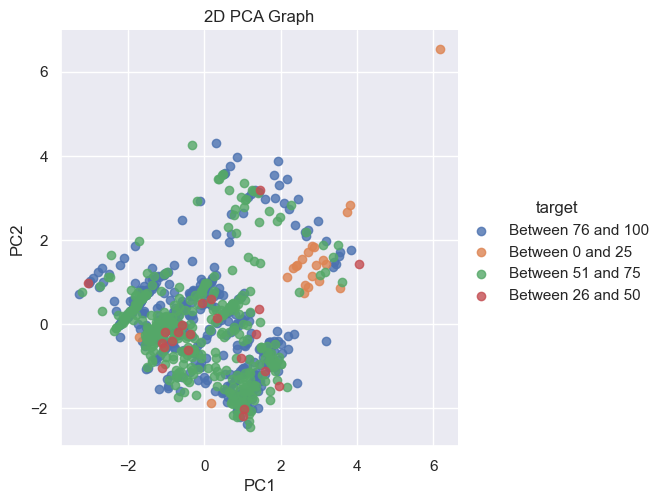

In [27]:
sns.set()

sns.lmplot(
    x='PC1',
    y='PC2',
    data=pca_df,
    hue='target',
    fit_reg=False,
    legend=True,
)

plt.title('2D PCA Graph')
plt.show()

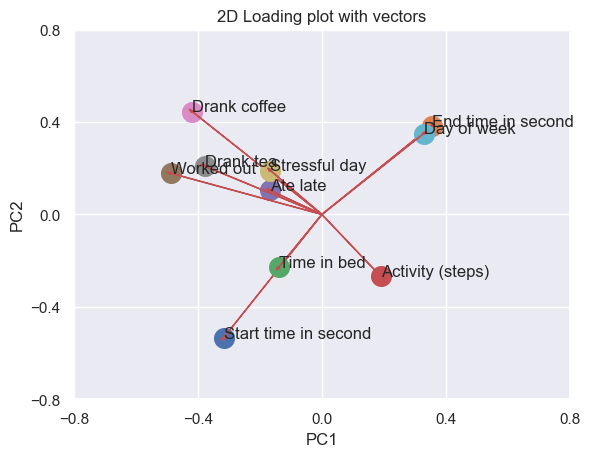

In [28]:
# Principal components correlation coefficients
loadings = pca.components_

# Number of features before PCA
n_features = pca.n_features_

# Feature names before PCA
feature_names = labels

# PC names
pc_list = [f'PC{i}' for i in list(range(1, n_features + 1))]

# Match PC names to loadings
pc_loadings = dict(zip(pc_list, loadings))

# Matrix of corr coefs between feature names and PCs
loadings_df = pd.DataFrame.from_dict(pc_loadings)
loadings_df['feature_names'] = feature_names
loadings_df = loadings_df.set_index('feature_names')

# Get the loadings of x and y axes
xs = loadings[0]
ys = loadings[1]

# Plot the loadings on a scatterplot
for i, varnames in enumerate(feature_names):
    plt.scatter(xs[i], ys[i], s=200)
    plt.arrow(
        0, 0, # coordinates of arrow base
        xs[i], # length of the arrow along x
        ys[i], # length of the arrow along y
        color='r',
        head_width=0.01
    )
    plt.text(xs[i], ys[i], varnames)

# Define the axes
xticks = np.linspace(-0.8, 0.8, num=5)
yticks = np.linspace(-0.8, 0.8, num=5)
plt.xticks(xticks)
plt.yticks(yticks)
plt.xlabel('PC1')
plt.ylabel('PC2')

# Show plot
plt.title('2D Loading plot with vectors')
plt.show()

## Association rules

In [29]:
rules_dataset=final_dataset.copy()
rules_dataset['Sleep quality']=df_cleaned['Sleep quality']

In [30]:
scaled_features_df = pd.DataFrame(standardized_X, index=final_dataset.index, columns=final_dataset.columns)

In [31]:
rules_dataset["Sleep quality"]=pd.cut(df_cleaned['Sleep quality'], bins=4, labels=False)
target_names = {
    0:"Between 0 and 25",
    1:"Between 26 and 50",
    2:"Between 51 and 75",
    3:"Between 76 and 100"
}
rules_dataset["Sleep quality"]=rules_dataset["Sleep quality"].map(target_names)

In [32]:
rules_dataset

,Start time in second,End time in second,Time in bed,Activity (steps),Ate late,Worked out,Drank coffee,Drank tea,Stressful day,Day of week,Sleep quality
0,82669,27013,30744.0,0,0,0,0,0,0,0,Between 76 and 100
1,76670,77634,964.0,0,0,0,0,0,1,1,Between 0 and 25
2,81769,26011,30642.0,0,0,0,0,0,0,1,Between 76 and 100
3,81061,21781,27120.0,0,0,0,0,0,0,2,Between 51 and 75
4,79930,17795,24265.0,0,0,0,1,1,0,3,Between 51 and 75
...,...,...,...,...,...,...,...,...,...,...,...
882,78854,25335,32881.0,56,0,0,0,0,0,0,Between 76 and 100
883,85759,25253,25894.0,64,0,0,0,0,0,1,Between 76 and 100
884,77045,22852,32207.0,3316,0,0,0,0,0,2,Between 51 and 75
885,77792,24631,33239.0,6555,0,0,0,0,0,3,Between 76 and 100


<AxesSubplot:>

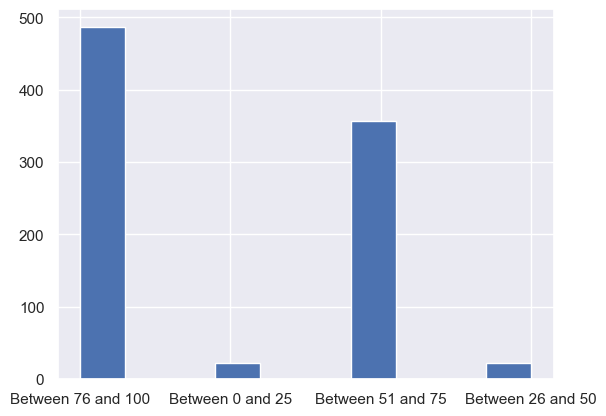

In [33]:
rules_dataset['Sleep quality'].hist()

In [34]:
rules_dataset=pd.get_dummies(rules_dataset,columns=['Sleep quality'])

In [35]:
rules_dataset=rules_dataset.drop(['Start time in second','End time in second','Time in bed','Activity (steps)','Day of week'],axis=1)

In [36]:
er = apriori(rules_dataset, min_support = 0.2, use_colnames = True, verbose = 1)
df_ar = association_rules(er, metric = "confidence", min_threshold = 0.2)
df_ar.head(15)

Processing 4 combinations | Sampling itemset size 43


C:\Users\Aarongp\anaconda3\envs\DataMiningAssignments\lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:111: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(Worked out),(Drank coffee),0.410372,0.590755,0.333709,0.813187,1.376520,0.091280,2.190663
1,(Drank coffee),(Worked out),0.590755,0.410372,0.333709,0.564885,1.376520,0.091280,1.355110
2,(Drank tea),(Worked out),0.514092,0.410372,0.286359,0.557018,1.357348,0.075389,1.331041
3,(Worked out),(Drank tea),0.410372,0.514092,0.286359,0.697802,1.357348,0.075389,1.607912
4,(Sleep quality_Between 76 and 100),(Worked out),0.549042,0.410372,0.223224,0.406571,0.990737,-0.002087,0.993595
5,(Worked out),(Sleep quality_Between 76 and 100),0.410372,0.549042,0.223224,0.543956,0.990737,-0.002087,0.988848
6,(Drank tea),(Drank coffee),0.514092,0.590755,0.372041,0.723684,1.225015,0.068338,1.481076
7,(Drank coffee),(Drank tea),0.590755,0.514092,0.372041,0.629771,1.225015,0.068338,1.312451
8,(Drank coffee),(Sleep quality_Between 51 and 75),0.590755,0.401353,0.240135,0.406489,1.012796,0.003034,1.008653
9,(Sleep quality_Between 51 and 75),(Drank coffee),0.401353,0.590755,0.240135,0.598315,1.012796,0.003034,1.018819


# CV

In [37]:
##### Warnings, maybe not have ?
import warnings
warnings.filterwarnings('ignore')

In [38]:
#for testing the code:
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data[:, :2]
y = iris.target


In [39]:
#our values standardized
X=scaled_features_df.values
y=pd.cut(df_cleaned['Sleep quality'], bins=4, labels=False)
y

0      3
1      0
2      3
3      2
4      2
      ..
882    3
883    3
884    2
885    3
886    3
Name: Sleep quality, Length: 887, dtype: int64

#### One iteration:

In [40]:
x_train,x_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

weigths=len(y_train) / (4 * np.bincount(y_train))#weigths if the classes. We use weigths because the data is not balanced
sample_weight=y_train.map(dict(zip([0,1,2,3], weigths)))


knn_model = KNeighborsClassifier(n_neighbors=3).fit(x_train, y_train)
nb_model=GaussianNB().fit(x_train, y_train,sample_weight)
sv_model = SVC(class_weight='balanced').fit(x_train, y_train)
dt_model=DecisionTreeClassifier(class_weight='balanced').fit(x_train, y_train)

print(dt_model.score(x_test,y_test),
      sv_model.score(x_test,y_test),
      nb_model.score(x_test,y_test),
      knn_model.score(x_test,y_test))

0.5767918088737202 0.552901023890785 0.08191126279863481 0.5631399317406144


## CV, before tuning

In [41]:
accuracy_list_K_nearest_neighbor =[]
accuracy_list_naive_bayes =[]
accuracy_list_support_vector =[]
accuracy_list_decision_tree =[]

In [42]:
for i in range(100):
    x_train,x_test, y_train, y_test = train_test_split(X, y, test_size=np.random.uniform(low=0.2,high=0.35))
    weigths=len(y_train) / (4 * np.bincount(y_train))#weigths if the classes. We use weigths because the data is not balanced
    sample_weight=y_train.map(dict(zip([0,1,2,3], weigths)))
    """Fitting each model"""
    knn_model = KNeighborsClassifier(n_neighbors=3).fit(x_train, y_train)
    nb_model=GaussianNB().fit(x_train, y_train,sample_weight)
    sv_model = SVC(class_weight='balanced').fit(x_train, y_train)
    dt_model=DecisionTreeClassifier(class_weight='balanced').fit(x_train, y_train)

    """Appending accuracy""" 
    accuracy_list_K_nearest_neighbor.append(knn_model.score(x_test,y_test))
    accuracy_list_naive_bayes.append(nb_model.score(x_test,y_test))
    accuracy_list_support_vector.append(sv_model.score(x_test,y_test))
    accuracy_list_decision_tree.append(dt_model.score(x_test,y_test))

accuracies=(accuracy_list_K_nearest_neighbor,
    accuracy_list_naive_bayes,
    accuracy_list_support_vector,
    accuracy_list_decision_tree)

print(f' accuracy for k-nn is: {np.mean(accuracy_list_K_nearest_neighbor)}')
print(f' accuracy for support vectors is: {np.mean(accuracy_list_support_vector)}')
print(f' accuracy for naive bayes is: {np.mean(accuracy_list_naive_bayes)}')
print(f' accuracy for decision trees is: {np.mean(accuracy_list_decision_tree)}')
print(f' mean accuracy is: {np.mean([np.mean(x) for x in accuracies])}')
print(f' best accuracy is: {max([np.mean(x) for x in accuracies])}')

 accuracy for k-nn is: 0.606906374197984
 accuracy for support vectors is: 0.5909895590838947
 accuracy for naive bayes is: 0.09023133970958908
 accuracy for decision trees is: 0.581417332388027
 mean accuracy is: 0.4673861513448737
 best accuracy is: 0.606906374197984


## Hyperparameterization

In [43]:
#decision trees
weigths=len(y_train) / (4 * np.bincount(y_train))#weigths if the classes. We use weigths because the data is not balanced
sample_weight=y_train.map(dict(zip([0,1,2,3], weigths)))

grid = {'criterion': ['gini', 'entropy', 'log_loss'],'splitter': ["best","random"],'min_samples_leaf':[1,2,3,4,5]}
classifier=DecisionTreeClassifier(random_state=42,class_weight='balanced')
grid_search = GridSearchCV(estimator=classifier, param_grid=grid, cv= 5)
grid_search.fit(x_train, y_train)
random_search = RandomizedSearchCV(estimator = classifier, param_distributions = grid, n_iter = 5, cv = 5, n_jobs = -1, verbose = 0)
random_search.fit(x_train,y_train)

print(random_search.best_params_,random_search.score(x_test,y_test)) 
print(grid_search.best_params_,grid_search.score(x_test,y_test))  

{'splitter': 'best', 'min_samples_leaf': 1, 'criterion': 'entropy'} 0.5901639344262295
{'criterion': 'entropy', 'min_samples_leaf': 1, 'splitter': 'best'} 0.5901639344262295


In [44]:
#knn, commented bc takes time
weigths=len(y_train) / (4 * np.bincount(y_train))#weigths if the classes. We use weigths because the data is not balanced
sample_weight=y_train.map(dict(zip([0,1,2,3], weigths)))

grid = {'n_neighbors' : np.random.randint(1,50,10), 
        'weights':['uniform','distance'], 
        'algorithm':['auto','ball_tree','kd_tree','brute'], 
        'leaf_size':[int(x) for x in np.linspace(start = 0, stop = 300, num=10)],
        'p':[1,2,3,4,5]}
classifier = KNeighborsClassifier()
grid_search = GridSearchCV(estimator=classifier, param_grid=grid, cv= 5)
grid_search.fit(x_train, y_train)
random_search = RandomizedSearchCV(estimator = classifier, param_distributions = grid, n_iter = 5, cv = 5, n_jobs = -1, verbose = 0)
random_search.fit(x_train,y_train)

print(random_search.best_params_,random_search.score(x_test,y_test)) # why is this 0.78 but next cell is 0.04
print(grid_search.best_params_,grid_search.score(x_test,y_test)) # why so different? grid same always 

"""{'weights': 'distance', 'p': 4, 'n_neighbors': 30, 'leaf_size': 133, 'algorithm': 'ball_tree'} 0.8532423208191127
{'algorithm': 'auto', 'leaf_size': 33, 'n_neighbors': 14, 'p': 1, 'weights': 'uniform'} 0.8532423208191127"""


{'weights': 'distance', 'p': 4, 'n_neighbors': 7, 'leaf_size': 133, 'algorithm': 'brute'} 0.6338797814207651
{'algorithm': 'auto', 'leaf_size': 33, 'n_neighbors': 27, 'p': 1, 'weights': 'distance'} 0.6502732240437158


"{'weights': 'distance', 'p': 4, 'n_neighbors': 30, 'leaf_size': 133, 'algorithm': 'ball_tree'} 0.8532423208191127\n{'algorithm': 'auto', 'leaf_size': 33, 'n_neighbors': 14, 'p': 1, 'weights': 'uniform'} 0.8532423208191127"

In [45]:
# SVC
# Error "X should be a square kernel matrix"? : ## Ok precomputed was the problem
weigths=len(y_train) / (4 * np.bincount(y_train))#weigths if the classes. We use weigths because the data is not balanced
sample_weight=y_train.map(dict(zip([0,1,2,3], weigths)))

grid = {'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],'gamma': ['scale', 'auto'],'degree':[1,2,3,4]} # not inclded precomputed
classifier=SVC(class_weight='balanced')
grid_search = GridSearchCV(estimator=classifier, param_grid=grid, cv= 5) 
grid_search.fit(x_train, y_train)
random_search = RandomizedSearchCV(estimator = classifier, param_distributions = grid, n_iter = 5, cv = 5, n_jobs = -1, verbose = 0)
random_search.fit(x_train,y_train)

print(random_search.best_params_,random_search.score(x_test,y_test)) # why is this 0.78 but next cell is 0.04
print(grid_search.best_params_,grid_search.score(x_test,y_test)) # why so different? grid same always 

"""{'kernel': 'linear', 'gamma': 'auto', 'degree': 3} 0.8498293515358362
{'degree': 1, 'gamma': 'scale', 'kernel': 'linear'} 0.8498293515358362"""

{'kernel': 'rbf', 'gamma': 'scale', 'degree': 3} 0.5956284153005464
{'degree': 3, 'gamma': 'scale', 'kernel': 'poly'} 0.6284153005464481


"{'kernel': 'linear', 'gamma': 'auto', 'degree': 3} 0.8498293515358362\n{'degree': 1, 'gamma': 'scale', 'kernel': 'linear'} 0.8498293515358362"

In [46]:
#NB
weigths=len(y_train) / (4 * np.bincount(y_train))#weigths if the classes. We use weigths because the data is not balanced
sample_weight=y_train.map(dict(zip([0,1,2,3], weigths)))

grid = {'var_smoothing': np.logspace(0,-9, num=100)}
classifier = GaussianNB()
grid_search = GridSearchCV(estimator=classifier, param_grid=grid, cv= 5)
grid_search.fit(x_train, y_train,sample_weight=sample_weight)
random_search = RandomizedSearchCV(estimator = classifier, param_distributions = grid, n_iter = 5, cv = 5, n_jobs = -1, verbose = 0)
random_search.fit(x_train,y_train)

print(random_search.best_params_,random_search.score(x_test,y_test)) # why is this 0.78 but next cell is 0.04
print(grid_search.best_params_,grid_search.score(x_test,y_test)) # why so different? grid same always 

"""{'var_smoothing': 1.0} 0.8498293515358362
{'var_smoothing': 1.0} 0.8498293515358362"""

{'var_smoothing': 0.001873817422860383} 0.6174863387978142
{'var_smoothing': 1.0} 0.5683060109289617


"{'var_smoothing': 1.0} 0.8498293515358362\n{'var_smoothing': 1.0} 0.8498293515358362"

## CV, after tuning

In [47]:
accuracy_list_K_nearest_neighbor =[]
accuracy_list_naive_bayes =[]
accuracy_list_support_vector =[]
accuracy_list_decision_tree =[]

In [48]:
#for 4 bins we get:
#{'var_smoothing': 0.3511191734215131} 
#{'kernel': 'linear', 'gamma': 'scale', 'degree': 1}
#{'criterion': 'gini', 'min_samples_leaf': 5, 'splitter': 'best'}
#{'algorithm': 'auto', 'leaf_size': 66, 'n_neighbors': 31, 'p': 1, 'weights': 'uniform'}
weigths=len(y_train) / (4 * np.bincount(y_train))#weigths if the classes. We use weigths because the data is not balanced
sample_weight=y_train.map(dict(zip([0,1,2,3], weigths)))

for i in range(100): #Change after doing on real data 
    x_train,x_test, y_train, y_test = train_test_split(X, y, test_size=np.random.uniform(low=0.2,high=0.35))
    weigths=len(y_train) / (4 * np.bincount(y_train))#weigths if the classes. We use weigths because the data is not balanced
    sample_weight=y_train.map(dict(zip([0,1,2,3], weigths)))
    """Fitting each model"""

    knn_model = KNeighborsClassifier(weights='uniform', p=1, n_neighbors= 23,
                                     leaf_size=33, algorithm='auto').fit(x_train, y_train)
    nb_model=GaussianNB(var_smoothing= 0.3511191734215131,).fit(x_train, y_train,sample_weight)
    sv_model = SVC(degree=1, gamma='scale', kernel= 'rbf',class_weight='balanced').fit(x_train, y_train)
    dt_model=DecisionTreeClassifier(criterion='gini', min_samples_leaf= 4, splitter='best',class_weight='balanced').fit(x_train, y_train)

    """Appending accuracy""" 
    accuracy_list_K_nearest_neighbor.append(knn_model.score(x_test,y_test))
    accuracy_list_naive_bayes.append(nb_model.score(x_test,y_test))
    accuracy_list_support_vector.append(sv_model.score(x_test,y_test))
    accuracy_list_decision_tree.append(dt_model.score(x_test,y_test))
accuracies=(accuracy_list_K_nearest_neighbor,
    accuracy_list_naive_bayes,
    accuracy_list_support_vector,
    accuracy_list_decision_tree)

print(f' accuracy for k-nn is: {np.mean(accuracy_list_K_nearest_neighbor)}')
print(f' accuracy for support vectors is: {np.mean(accuracy_list_support_vector)}')
print(f' accuracy for naive bayes is: {np.mean(accuracy_list_naive_bayes)}')
print(f' accuracy for decision trees is: {np.mean(accuracy_list_decision_tree)}')
print(f' mean accuracy is: {np.mean([np.mean(x) for x in accuracies])}')
print(f' best accuracy is: {max([np.mean(x) for x in accuracies])}')

 accuracy for k-nn is: 0.627713456621873
 accuracy for support vectors is: 0.5934546868842783
 accuracy for naive bayes is: 0.4561363123408801
 accuracy for decision trees is: 0.5627836214222363
 mean accuracy is: 0.5600220193173169
 best accuracy is: 0.627713456621873


## Variable importance

In [49]:
#np.random.seed(42) 

X_train,X_test, y_train, y_test = train_test_split(scaled_features_df, y, test_size=np.random.uniform(low=0.2,high=0.35))


test_variables=[['Time in bed'],['Start time in second'],['End time in second'],['Activity (steps)'], ['Drank tea'],['Drank coffee'], ['Worked out'], ['Ate late'], ['Stressful day']]
accuracy_list_support_vector_exl=[]
accuracy_list_support_vector_incl=[]

sv_model_org = SVC(degree=1, gamma='scale', kernel= 'rbf').fit(X_train, y_train)
org_score=sv_model_org.score(X_test,y_test)

for i in test_variables:
    x_train=X_train.drop(columns=i)
    x_test=X_test.drop(columns=i)    
    
    sv_model_e = SVC(degree=1, gamma='scale', kernel= 'rbf').fit(x_train, y_train)
    accuracy_list_support_vector_exl.append(sv_model_e.score(x_test,y_test))

for i in test_variables:
    x_train=X_train[i]
    x_test=X_test[i]

    sv_model_i = SVC(degree=1, gamma='scale', kernel= 'rbf').fit(x_train, y_train)
    accuracy_list_support_vector_incl.append(sv_model_i.score(x_test,y_test))

print(f"Original accuracy is {round(org_score,3)}")
for i,var in enumerate(test_variables):
    print(f'Variable "{var[0]}", accuracy when excluding is {round(accuracy_list_support_vector_exl[i],3)} and when excluding all else it is {round(accuracy_list_support_vector_incl[i],3)} ')

print(f"Original accuracy is {round(org_score,3)}")
for i,var in enumerate(test_variables):
    print(f'"{var[0]}" & {round(accuracy_list_support_vector_exl[i],3)} & {round(accuracy_list_support_vector_incl[i],3)} \\\ ')

print([x[0] for x in [['Time in bed'],['Start time in second'],['End time in second'],['Activity (steps)']]])

Original accuracy is 0.648
Variable "Time in bed", accuracy when excluding is 0.611 and when excluding all else it is 0.658 
Variable "Start time in second", accuracy when excluding is 0.637 and when excluding all else it is 0.591 
Variable "End time in second", accuracy when excluding is 0.653 and when excluding all else it is 0.56 
Variable "Activity (steps)", accuracy when excluding is 0.658 and when excluding all else it is 0.617 
Variable "Drank tea", accuracy when excluding is 0.622 and when excluding all else it is 0.57 
Variable "Drank coffee", accuracy when excluding is 0.648 and when excluding all else it is 0.57 
Variable "Worked out", accuracy when excluding is 0.653 and when excluding all else it is 0.57 
Variable "Ate late", accuracy when excluding is 0.658 and when excluding all else it is 0.57 
Variable "Stressful day", accuracy when excluding is 0.648 and when excluding all else it is 0.57 
Original accuracy is 0.648
"Time in bed" & 0.611 & 0.658 \\ 
"Start time in sec

In [50]:
import statistics

accuracy_list_exl=[]
accuracy_list_incl=[]
og_acc=[]
for _ in range(100):
    X_train,X_test, y_train, y_test = train_test_split(scaled_features_df, y, test_size=np.random.uniform(low=0.2,high=0.35))
    test_variables=[['Time in bed'],['Start time in second'],['End time in second'],['Activity (steps)'], ['Drank tea'],['Drank coffee'], ['Worked out'], ['Ate late'], ['Stressful day']]
    accuracy_list_support_vector_exl=[]
    accuracy_list_support_vector_incl=[]

    sv_model_org = SVC(degree=1, gamma='scale', kernel= 'rbf').fit(X_train, y_train)
    org_score=sv_model_org.score(X_test,y_test)
    og_acc.append(org_score)

    for i in test_variables:
        x_train=X_train.drop(columns=i)
        x_test=X_test.drop(columns=i)    

        sv_model_e = SVC(degree=1, gamma='scale', kernel= 'rbf').fit(x_train, y_train)
        accuracy_list_support_vector_exl.append(sv_model_e.score(x_test,y_test))

    for i in test_variables:
        x_train=X_train[i]
        x_test=X_test[i]

        sv_model_i = SVC(degree=1, gamma='scale', kernel= 'rbf').fit(x_train, y_train)
        accuracy_list_support_vector_incl.append(sv_model_i.score(x_test,y_test))
    
    accuracy_list_incl.append(accuracy_list_support_vector_incl)
    accuracy_list_exl.append(accuracy_list_support_vector_exl)
        

print(f"Original accuracy is {round(statistics.mean(og_acc),3)}, with a variance of {round(statistics.variance([item for item in og_acc]),3)}")
for i,var in enumerate(test_variables):
    print(f'"{var[0]}" & {round(statistics.mean([item[i] for item in accuracy_list_exl]),3)} & {round(statistics.mean([item[i] for item in accuracy_list_incl]),3)} &{round(statistics.variance([item[i] for item in accuracy_list_exl]),4)} &{round(statistics.variance([item[i] for item in accuracy_list_incl]),4)}\\\ ')


Original accuracy is 0.659, with a variance of 0.001
"Time in bed" & 0.595 & 0.64 &0.0007 &0.0008\\ 
"Start time in second" & 0.659 & 0.566 &0.0007 &0.0006\\ 
"End time in second" & 0.652 & 0.562 &0.0007 &0.0009\\ 
"Activity (steps)" & 0.629 & 0.593 &0.0007 &0.0007\\ 
"Drank tea" & 0.66 & 0.551 &0.0007 &0.0007\\ 
"Drank coffee" & 0.656 & 0.551 &0.0007 &0.0007\\ 
"Worked out" & 0.663 & 0.551 &0.0006 &0.0007\\ 
"Ate late" & 0.66 & 0.551 &0.0008 &0.0007\\ 
"Stressful day" & 0.655 & 0.551 &0.0008 &0.0007\\ 


In [51]:
#for the og acc, forgot in the code above 
print(round(statistics.mean([item for item in og_acc]),3),
round(statistics.variance([item for item in og_acc]),3))

0.659 0.001
